In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime

from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent

import sys
sys.path.append("../FinRL-Library")

import itertools

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\exchange_calendars\exchange_calendar.py:2347: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-07-01'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2023-05-01'

In [3]:
df_raw=pd.read_csv('datasets/BSE30.csv')

In [4]:
from dataprocessing import FeatureEngineer, load_dataset, data_split, convert_to_datetime

In [5]:
from finrl.config import INDICATORS
fe = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = INDICATORS,
                      use_vix=False,
                      use_turbulence=True,
                      user_defined_feature = False)

processed = fe.preprocess_data(df_raw)

Successfully added technical indicators


C:\Users\Vansh\Downloads\BTP-2-4-24\dataprocessing.py:236: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_price_pivot = df_price_pivot.pct_change()


Successfully added turbulence index


In [6]:
processed

date         open         high          low        close  \
0       2009-01-02    90.750000    90.750000    88.550003    48.861801   
1       2009-01-02   105.800003   109.599998   103.459999    71.914917   
2       2009-01-02   206.050003   210.500000   196.500000   158.413025   
3       2009-01-02    15.140000    15.800000    14.975000    13.401811   
4       2009-01-02     6.660000     6.970000     6.350000     2.746401   
...            ...          ...          ...          ...          ...   
105698  2023-04-28   981.000000   992.500000   979.250000   986.799988   
105699  2023-04-28  3208.000000  3227.199951  3197.149902  3175.769043   
105700  2023-04-28   983.000000  1026.650024   982.950012   986.955139   
105701  2023-04-28  2663.500000  2679.300049  2620.050049  2640.399902   
105702  2023-04-28  7524.950195  7576.549805  7487.549805  7520.226562   

         volume            tic  day       macd      boll_ub      boll_lb  \
0         19140  ASIANPAINT.BO    4   0.000000    50.523346    48.068260   
1       4536215    AXISBANK.BO    4   0.000000    50.523346    48.068260   
2         52648  BAJAJ-AUTO.BO    4   0.000000    50.523346    48.068260   
3        136590  BAJAJFINSV.BO    4   0.000000    50.523346    48.068260   
4        274220  BAJFINANCE.BO    4   0.000000    50.523346    48.068260   
...         ...            ...  ...        ...          ...          ...   
105698    26056   SUNPHARMA.BO    4  -0.263414  1019.314408   965.265603   
105699    51644         TCS.BO    4 -15.398183  3235.633708  3045.249324   
105700   279514       TECHM.BO    4 -22.941437  1102.074200   929.293964   
105701    32742       TITAN.BO    4  43.161331  2669.834479  2492.325506   
105702     8316  ULTRACEMCO.BO    4  28.692164  7774.630825  7303.703648   

            rsi_30      cci_30       dx_30  close_30_sma  close_60_sma  \
0       100.000000   66.666667  100.000000     48.861801     48.861801   
1       100.000000   66.666667  100.000000     71.914917     71.914917   
2       100.000000   66.666667  100.000000    158.413025    158.413025   
3       100.000000   66.666667  100.000000     13.401811     13.401811   
4       100.000000   66.666667  100.000000      2.746401      2.746401   
...            ...         ...         ...           ...           ...   
105698   50.085294   14.481255    1.567920    983.446670    985.046100   
105699   48.649310   67.966063    0.407494   3131.238102   3257.234477   
105700   44.970681  -99.119890   22.233939   1033.226742   1032.633037   
105701   60.306098  116.653875   37.463255   2542.391650   2482.099988   
105702   55.649892   27.765845    3.677975   7441.862826   7301.539185   

        turbulence  
0         0.000000  
1         0.000000  
2         0.000000  
3         0.000000  
4         0.000000  
...            ...  
105698   43.069415  
105699   43.069415  
105700   43.069415  
105701   43.069415  
105702   43.069415  

[105703 rows x 17 columns]

In [7]:
df=processed

In [8]:
list_ticker = df["tic"].unique().tolist()
# only apply to daily level data, need to fix for minute level
list_date = list(pd.date_range(df['date'].min(),df['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
df_full = df_full[df_full['date'].isin(df['date'])]
df_full = df_full.sort_values(['date','tic'])
df_full = df_full.fillna(1)

In [9]:
df=df_full

In [10]:
from TradingEnv import StockTradingEnv

In [11]:
train = data_split(df, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(df, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))
     

77550
21120


In [13]:
train.to_csv('train_data.csv')
trade.to_csv('trade_data.csv')

In [14]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 301


In [15]:
train.head()

date            tic        open        high         low       close  \
0  2010-01-04  ASIANPAINT.BO  173.800003  179.990005  173.800003  113.311302   
0  2010-01-04    AXISBANK.BO  199.800003  199.800003  197.600006  142.226456   
0  2010-01-04  BAJAJ-AUTO.BO  885.000000  886.000000  865.000000  687.819336   
0  2010-01-04  BAJAJFINSV.BO   34.900002   36.080002   34.799999   31.331820   
0  2010-01-04  BAJFINANCE.BO   33.270000   34.389999   33.270000   16.682077   

      volume  day       macd     boll_ub     boll_lb     rsi_30      cci_30  \
0    26700.0  0.0   2.051069  115.089549  104.640905  66.436248  113.218646   
0   658270.0  0.0  -0.338474  151.029051  132.164238  52.578761   -1.919545   
0    71150.0  0.0  16.282086  707.370571  641.819761  61.119288   90.337046   
0  1119010.0  0.0   0.473058   30.449640   27.363217  60.736230  321.150339   
0   221680.0  0.0   0.568160   16.397749   14.096924  68.269383  212.436642   

       dx_30  close_30_sma  close_60_sma  turbulence  
0  24.458130    108.824595    104.144379         0.0  
0   2.331440    142.339130    140.995590         0.0  
0  15.068862    655.815855    622.730791         0.0  
0  46.461213     28.700716     28.163338         0.0  
0  27.581496     14.887369     14.188843         0.0

In [16]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [23]:
from finrl.agents.stablebaselines3.models import DRLEnsembleAgent
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=df,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)

In [24]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000, 
                 'ppo' : 10_000, 
                 'ddpg' : 10_000
                 }

In [25]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  180.74924550975138
======Model training from:  2010-01-01 to  2020-07-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device


C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Logging to tensorboard_log/a2c\a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 56        |
|    iterations         | 100       |
|    time_elapsed       | 8         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.7     |
|    explained_variance | -0.00221  |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -36.8     |
|    reward             | 1.6071275 |
|    std                | 1         |
|    value_loss         | 1.1       |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 57         |
|    iterations         | 200        |
|    time_elapsed       | 17         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.7      |
|    explained_variance | 0          |


C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 56         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.6      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -88.8      |
|    reward             | 0.31931126 |
|    std                | 1          |
|    value_loss         | 4.38       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 56        |
|    iterations         | 200       |
|    time_elapsed       | 17        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 55         |
|    iterations         | 100        |
|    time_elapsed       | 9          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.4      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -61.6      |
|    reward             | 0.20128012 |
|    std                | 0.995      |
|    value_loss         | 2.2        |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 54        |
|    iterations         | 200       |
|    time_elapsed       | 18        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-------------------------------------
| time/                 |           |
|    fps                | 54        |
|    iterations         | 100       |
|    time_elapsed       | 9         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -144      |
|    reward             | 1.4038739 |
|    std                | 1         |
|    value_loss         | 13.1      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 53        |
|    iterations         | 200       |
|    time_elapsed       | 18        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 53          |
|    iterations         | 100         |
|    time_elapsed       | 9           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -42.6       |
|    explained_variance | 0.0103      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -29.3       |
|    reward             | 0.058217335 |
|    std                | 1           |
|    value_loss         | 1.28        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 53        |
|    iterations         | 200       |
|    time_elapsed       | 18        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 0         |
|    learning_rate

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 52         |
|    iterations         | 100        |
|    time_elapsed       | 9          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -64.7      |
|    reward             | 0.13314308 |
|    std                | 0.998      |
|    value_loss         | 2.6        |
--------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 52       |
|    iterations         | 200      |
|    time_elapsed       | 18       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -42.5    |
|    explained_variance | 5.96e-08 |
|    learning_rate      | 0.0007   |
|    n

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 50          |
|    iterations         | 100         |
|    time_elapsed       | 9           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -42.6       |
|    explained_variance | 1.19e-07    |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -31.1       |
|    reward             | -0.10632927 |
|    std                | 1           |
|    value_loss         | 0.655       |
---------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 50         |
|    iterations         | 200        |
|    time_elapsed       | 19         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.5      |
|    explained_variance | 0          |
|    lear

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


-------------------------------------
| time/                 |           |
|    fps                | 49        |
|    iterations         | 100       |
|    time_elapsed       | 10        |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -98.1     |
|    reward             | 0.3647933 |
|    std                | 0.998     |
|    value_loss         | 5.64      |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 49        |
|    iterations         | 200       |
|    time_elapsed       | 20        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.5     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007    |
|    n_updat

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


--------------------------------------
| time/                 |            |
|    fps                | 60         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -42.7      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -126       |
|    reward             | 0.70934504 |
|    std                | 1.01       |
|    value_loss         | 9.88       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 61         |
|    iterations         | 200        |
|    time_elapsed       | 16         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -42.7      |
|    explained_variance | 0          |
|    learning_rate      |

C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


---------------------------------------
| time/                 |             |
|    fps                | 57          |
|    iterations         | 100         |
|    time_elapsed       | 8           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -42.7       |
|    explained_variance | -1.19e-07   |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | -63.9       |
|    reward             | -0.46497214 |
|    std                | 1           |
|    value_loss         | 3.08        |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 57        |
|    iterations         | 200       |
|    time_elapsed       | 17        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -42.6     |
|    explained_variance | 0         |
|    learning_rate

In [26]:
unique_trade_date = processed[(processed.date > TRADE_START_DATE)&(processed.date <= TRADE_END_DATE)].date.unique()

In [27]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.6568886906896435


In [28]:
df_account_value.tail()

account_value        date  daily_return    datadate
625   1.651971e+06  2023-04-06     -0.000992  2023-04-06
626   1.655904e+06  2023-04-10      0.002381  2023-04-10
627   1.664557e+06  2023-04-11      0.005226  2023-04-11
628   1.653694e+06  2023-04-12     -0.006527  2023-04-12
629   1.646168e+06  2023-04-13     -0.004551  2023-04-13

<Axes: >

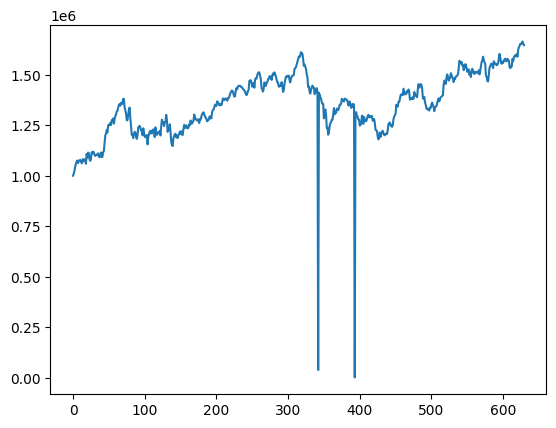

In [29]:
%matplotlib inline
df_account_value.account_value.plot()

In [30]:
from finrl.plot import backtest_stats
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)


C:\Users\Vansh\anaconda3\envs\tf_gpu\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


==============Get Backtest Results===========
Annual return            0.220646
Cumulative returns       0.646168
Annual volatility      562.434010
Sharpe ratio             0.656889
Calmar ratio             0.220848
Stability                0.044634
Max drawdown            -0.999085
Omega ratio            195.379420
Sortino ratio          413.397451
Skew                          NaN
Kurtosis                      NaN
Tail ratio               1.195995
Daily value at risk    -69.393927
dtype: float64


In [34]:
ensemble_agent.save("ensemble_model")

AttributeError: 'DRLEnsembleAgent' object has no attribute 'save'

In [33]:
import os
save_dir = "saved_strategy"
os.makedirs(save_dir, exist_ok=True)

# Save trained models
model_a2c.save(os.path.join(save_dir, "model_a2c"))
model_ppo.save(os.path.join(save_dir, "model_ppo"))
model_ddpg.save(os.path.join(save_dir, "model_ddpg"))

# Save metadata
metadata = {
    "A2C_model_kwargs": A2C_model_kwargs,
    "PPO_model_kwargs": PPO_model_kwargs,
    "DDPG_model_kwargs": DDPG_model_kwargs,
    "timesteps_dict": timesteps_dict,
    # Add any other relevant metadata
}
with open(os.path.join(save_dir, "metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)

# Save summary DataFrame
df_summary.to_csv(os.path.join(save_dir, "summary.csv"), index=False)

NameError: name 'model_ppo' is not defined

In [ ]:
df_summary.to_csv('df_summary')